In [1]:
# import libraries
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
#import torch.optim as optim
#from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torch.nn.functional as F
from torch.autograd import Variable
#from spectral import SpectralNorm

In [2]:
# load data
# Root directory for dataset
dataroot = "data/celeba"
# Number of workers for dataloader
workers = 2
# Batch size during training
batch_size = 8
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 8
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Number of training epochs
num_epochs = 2
# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [3]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
#NUM_VAL = 1000

train_color = transforms.Compose([
    #transforms.Resize(size=(64, 64)),
    #torchvision.transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Grayscale(3)
])

train_gray = transforms.Compose([
    transforms.Grayscale(),
    #transforms.Resize(size=(64, 64)),
    
    #torchvision.transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    
])

cifar10_color = dset.CIFAR10('/content/drive/My Drive/comp4471_assignment2/assignment2/cs231n/datasets/cifar-10-batches-py', train=True, download=True,
                           transform=train_color)
loader_color = DataLoader(cifar10_color, batch_size=8, sampler=ChunkSampler(NUM_TRAIN, 0))

cifar10_gray = dset.CIFAR10('/content/drive/My Drive/comp4471_assignment2/assignment2/cs231n/datasets/cifar-10-batches-py', train=True, download=True,
                           transform=train_gray)
loader_gray = DataLoader(cifar10_gray, batch_size=8, sampler=ChunkSampler(NUM_TRAIN, 0))

cifar10_test = dset.CIFAR10('/content/drive/My Drive/comp4471_assignment2/assignment2/cs231n/datasets/cifar-10-batches-py', train=False, download=True,
                          transform=transforms.ToTensor())
loader_test = DataLoader(cifar10_test, batch_size=8, sampler=ChunkSampler(NUM_TRAIN+1000, NUM_TRAIN))


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=3, H=32, W=32):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)


In [5]:
# weight initialization
 #custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self, in_dim):
        super().__init__()
        
        # Construct the module
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//2 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//2 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax  = nn.Softmax(dim=-1)
        
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B * C * W * H)
            returns :
                out : self attention value + input feature 
                attention: B * N * N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        
        proj_query  = self.query_conv(x).view(m_batchsize, -1, width*height).permute(0,2,1) # B * N * C
        proj_key =  self.key_conv(x).view(m_batchsize, -1, width*height) # B * C * N
        energy =  torch.bmm(proj_query, proj_key) # batch matrix-matrix product
        
        attention = self.softmax(energy) # B * N * N
        proj_value = self.value_conv(x).view(m_batchsize, -1, width*height) # B * C * N
        out = torch.bmm(proj_value, attention.permute(0,2,1)) # batch matrix-matrix product
        out = out.view(m_batchsize,C,width,height) # B * C * W * H
        
        out = self.gamma*out + x
        return out, attention

In [7]:
# generator
class Generator(nn.Module):
    def unet_conv(self, ch_in, ch_out, is_leaky = True):
        """
        Construct a convolutional unit comprising of two conv layers
        followed by a batch normalisation layer and ReLU/Leaky ReLU.
        """
        if is_leaky:
            return nn.Sequential(
                nn.Conv2d(ch_in, ch_out, 3, padding=1),
                nn.BatchNorm2d(ch_out),
                nn.LeakyReLU(0.2),
                nn.Conv2d(ch_out, ch_out, 3, padding=1),
                nn.BatchNorm2d(ch_out),
                nn.LeakyReLU(0.2)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(ch_in, ch_out, 3, padding=1),
                nn.BatchNorm2d(ch_out),
                nn.ReLU(),
                nn.Conv2d(ch_out, ch_out, 3, padding=1),
                nn.BatchNorm2d(ch_out),
                nn.ReLU()
            )
        
    def up(self, ch_in, ch_out):
        """
        Applies a 2D bilinear upsampling to the input image which scales
        the image 2x times, followed by a convolution with a 1x1 kernel. 
        """
        return nn.Sequential(
            nn.ConvTranspose2d(ch_in, ch_out, 3, 2, 1, 1), 
            
            nn.ReLU()
        )
    
    def __init__(self, is_leaky = True):
        """
        In the constructer, all the convolutional, upsampling and max pooling 
        units are instantiated and assigned as member variables. 
        """
        super(Generator, self).__init__()
        
        
        # First encoding layer
        self.conv1 = self.unet_conv(1, 64, is_leaky)
        
        # Second encoding layer
        self.conv2 = self.unet_conv(64, 128, is_leaky)
        
        # Third encoding layer
        self.conv3 = self.unet_conv(128, 256, is_leaky)
        # Fourth encoding layer
        #self.conv4 = self.unet_conv(256, 512, is_leaky)
        # Fifth encoding layer
        #self.conv5 = self.unet_conv(512, 1024, is_leaky)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2)
        
        # First Upsampling layer
        #self.up1 = self.up(1024, 512)
        # Second Upsampling layer
        self.up2 = self.up(512, 256)
        # Third Upsampling layer
        self.up3 = self.up(256, 128)
        # Fourth Upsampling layer
        self.up4 = self.up(128, 64)
        
        # First decoding layer
        #self.conv6 = self.unet_conv(1024, 512, False)
        # Second decoding layer
        #self.conv7 = self.unet_conv(512, 256, False)
        # Third decoding layer
        self.conv8 = self.unet_conv(256, 128, False)
        self.attn1 = Self_Attn(128)
        # Fourth decoding layer
        self.conv9 = self.unet_conv(128, 64, False)
        self.attn2 = Self_Attn(64)
        
        # Last layer
        self.conv10 = nn.Conv2d(64, 3, 1)
        self.attn3 = Self_Attn(256)
        self.attn4 = Self_Attn(512)
        

    def forward(self, x):
        """ 
        An input tensor of a black and white image is accepted and
        passed through the U-Net model. A colored image in CieLAB color
        space is returned as the result. 
        """
        # Encoding path
        x1 = self.conv1(x)
        #x1, _ = self.attn2(x1)
        x2 = self.conv2(self.pool(x1))
        #x2, _ = self.attn1(x2)
        x3 = self.conv3(self.pool(x2))
        #x4 = self.conv4(self.pool(x3))
        #x5 = self.conv5(self.pool(x4))
        
        # Decoding path
        #x = self.conv6(torch.cat((x4, self.up1(x5)), 1))
        #x, _ = self.attn4(x)
        #x = self.conv7(torch.cat((x3, self.up2(x4)), 1))
        #x,_ = self.attn3(x)
        x = self.conv8(torch.cat((x2, self.up3(x3)), 1))
        x, _ = self.attn1(x)
        x = self.conv9(torch.cat((x1, self.up4(x)), 1))
        x, _ = self.attn2(x)
        x = self.conv10(x)
        m = nn.Tanh()
        x = m(x)
        
        return x
    

In [8]:
# Create the generator
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
netG = Generator().to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2

In [9]:
# discriminator
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        #self.attn1 = 
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 3, 1, 1),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2,2),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2,2),
            #state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2,2),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2,2),
            nn.Conv2d(ndf * 8, ndf * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2,2),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 3, 1, 1, bias=False),
            nn.Sigmoid(),
            
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, ker

In [11]:
# loss function
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, 3, 64, 64, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(beta1, 0.9))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(beta1, 0.9))

In [12]:
data_dict = {}
for i,data in enumerate(loader_color, 0):
  data_dict["color"+str(i)] = data

for i,data in enumerate(loader_gray, 0):
  data_dict["gray"+str(i)] = data

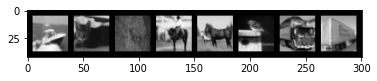

In [13]:
gray = data_dict["gray1"]
plt.imshow(np.transpose(vutils.make_grid(gray[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

In [14]:
# train
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

num = NUM_TRAIN//8
print("Starting Training Loop...")
# For each epoch
for epoch in range(5):
    # For each batch in the dataloader
    for i in range(num):
        
        data = data_dict["color" + str(i)]
        gray_data = data_dict["gray" + str(i)]
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.shape[0]
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        #print(label)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        #print(output)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        #gray_data = next(iter(loader_gray))
        gray = gray_data[0].to(device)
        #print(gray.shape)
        # Generate fake image batch with G
        fake = netG(gray)
        #print(fake.shape)
        label.fill_(fake_label)
        #print(label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        #print(output)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(loader_color),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(loader_color)-1)):
            with torch.no_grad():
                fake = netG(gray).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/2][0/6250]	Loss_D: 1.4932	Loss_G: 1.1390	D(x): 0.3830	D(G(z)): 0.4093 / 0.3204
[0/2][50/6250]	Loss_D: 0.1869	Loss_G: 2.7304	D(x): 0.9169	D(G(z)): 0.0936 / 0.0655
[0/2][100/6250]	Loss_D: 0.0467	Loss_G: 4.0650	D(x): 0.9737	D(G(z)): 0.0198 / 0.0172
[0/2][150/6250]	Loss_D: 0.0135	Loss_G: 5.2571	D(x): 0.9931	D(G(z)): 0.0065 / 0.0053
[0/2][200/6250]	Loss_D: 1.3516	Loss_G: 0.8012	D(x): 0.5139	D(G(z)): 0.4913 / 0.4498
[0/2][250/6250]	Loss_D: 1.2758	Loss_G: 1.2346	D(x): 0.5068	D(G(z)): 0.4445 / 0.2917
[0/2][300/6250]	Loss_D: 1.3945	Loss_G: 1.1712	D(x): 0.5893	D(G(z)): 0.5768 / 0.3119
[0/2][350/6250]	Loss_D: 1.4090	Loss_G: 0.8749	D(x): 0.5068	D(G(z)): 0.5130 / 0.4199
[0/2][400/6250]	Loss_D: 1.3260	Loss_G: 1.0621	D(x): 0.5368	D(G(z)): 0.5014 / 0.3471
[0/2][450/6250]	Loss_D: 1.4220	Loss_G: 0.9951	D(x): 0.5415	D(G(z)): 0.5481 / 0.3703
[0/2][500/6250]	Loss_D: 1.3637	Loss_G: 0.9760	D(x): 0.4185	D(G(z)): 0.3878 / 0.3773
[0/2][550/6250]	Loss_D: 1.4186	Loss_G: 0.8393	D(x): 0

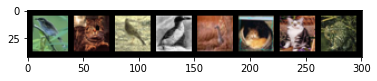

In [15]:
#plt.figure(figsize=(15,15))
color = data_dict["color100"]
plt.imshow(np.transpose(vutils.make_grid(color[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

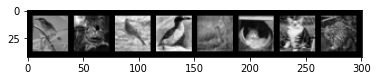

In [16]:
gray = data_dict["gray100"]
plt.imshow(np.transpose(vutils.make_grid(gray[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

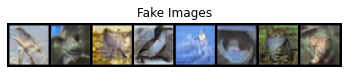

In [17]:
image_list = []
#plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Fake Images")
#fake_1 = netG(gray).detach().cpu()
with torch.no_grad():
          fake = netG(gray[0].to(device)).detach()
          fake = fake.cpu()
image_list.append(vutils.make_grid(fake, padding=2, normalize=True))
plt.imshow(np.transpose(image_list[-1],(1,2,0)))
plt.show()

In [18]:
fake[0]

tensor([[[0.5981, 0.6088, 0.6133,  ..., 0.5981, 0.6052, 0.6148],
         [0.6156, 0.6355, 0.6506,  ..., 0.6322, 0.6204, 0.6145],
         [0.6141, 0.6361, 0.6361,  ..., 0.6542, 0.6389, 0.6204],
         ...,
         [0.7371, 0.7696, 0.7667,  ..., 0.6618, 0.6672, 0.6174],
         [0.6834, 0.7016, 0.7179,  ..., 0.6060, 0.6632, 0.6276],
         [0.6296, 0.5825, 0.6045,  ..., 0.6540, 0.6677, 0.6012]],

        [[0.6479, 0.6681, 0.6756,  ..., 0.6636, 0.6689, 0.6840],
         [0.6555, 0.6860, 0.7009,  ..., 0.6938, 0.6803, 0.6844],
         [0.6504, 0.6801, 0.6719,  ..., 0.7051, 0.6934, 0.6859],
         ...,
         [0.7646, 0.7667, 0.7558,  ..., 0.6394, 0.6409, 0.6006],
         [0.6946, 0.6759, 0.6809,  ..., 0.5802, 0.6511, 0.6324],
         [0.6353, 0.5498, 0.5707,  ..., 0.6595, 0.6827, 0.6058]],

        [[0.6994, 0.7289, 0.7332,  ..., 0.7327, 0.7347, 0.7349],
         [0.7133, 0.7423, 0.7482,  ..., 0.7580, 0.7476, 0.7412],
         [0.6999, 0.7247, 0.6983,  ..., 0.7607, 0.7553, 0.

In [19]:
def similarity(fake, real):
  # fake and real are 8*3*32*32 tensors
  comparison = []
  for i in range(8):
    dot_prod = torch.sum(fake[i]*real[i])
    fake_norm = torch.norm(fake[i])
    real_norm = torch.norm(real[i])
    similarity = dot_prod/(fake_norm*real_norm)
    comparison.append(similarity.item())
    print(similarity)
  return np.mean(comparison)

print(similarity(fake, color[0]))

tensor(0.9777)
tensor(0.8964)
tensor(0.9730)
tensor(0.9806)
tensor(0.8489)
tensor(0.9169)
tensor(0.9332)
tensor(0.9698)
0.9370646551251411


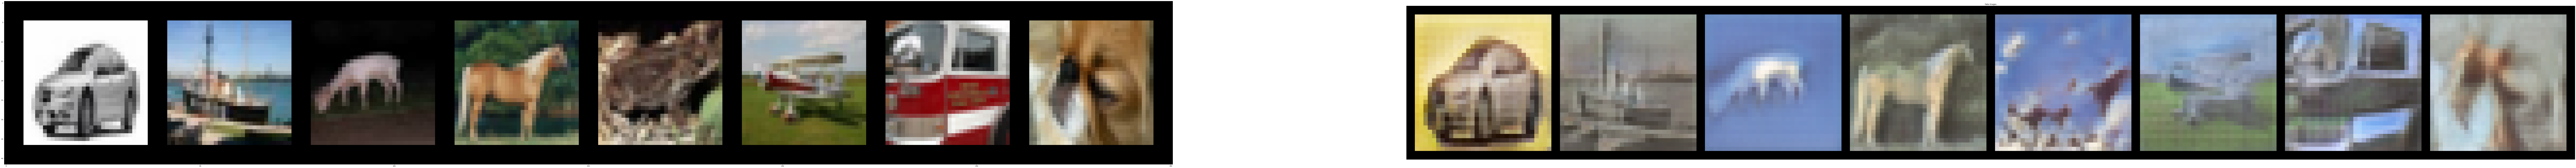

tensor(0.9528)
tensor(0.9621)
tensor(0.7213)
tensor(0.9669)
tensor(0.8893)
tensor(0.9614)
tensor(0.9473)
tensor(0.9671)
Similarity is 0.9209955036640167


In [20]:
plt.figure(figsize = (300, 300))

plt.subplot(3, 2, 1)
color = data_dict["color"+str(10*(1+1))]
plt.imshow(np.transpose(vutils.make_grid(color[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.subplot(3, 2, 2)
image_list = []
gray = data_dict["gray"+str(10*(1+1))]
#plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Fake Images")
#fake_1 = netG(gray).detach().cpu()
with torch.no_grad():
        fake = netG(gray[0].to(device)).detach()
        fake = fake.cpu()
image_list.append(vutils.make_grid(fake, padding=2, normalize=True))
plt.imshow(np.transpose(image_list[-1],(1,2,0)))
plt.show()
print("Similarity is", similarity(fake, color[0]))

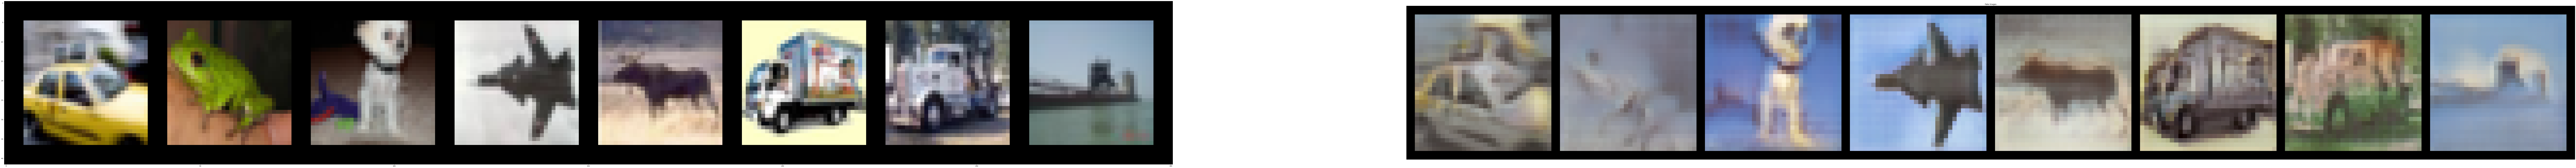

tensor(0.9578)
tensor(0.8476)
tensor(0.8914)
tensor(0.9753)
tensor(0.9892)
tensor(0.9639)
tensor(0.9599)
tensor(0.9727)
Similarity is 0.9447286799550056


In [21]:
plt.figure(figsize = (300, 300))

plt.subplot(3, 2, 1)
color = data_dict["color"+str(10*(150+1))]
plt.imshow(np.transpose(vutils.make_grid(color[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.subplot(3, 2, 2)
image_list = []
gray = data_dict["gray"+str(10*(150+1))]
#plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Fake Images")
#fake_1 = netG(gray).detach().cpu()
with torch.no_grad():
        fake = netG(gray[0].to(device)).detach()
        fake = fake.cpu()
image_list.append(vutils.make_grid(fake, padding=2, normalize=True))
plt.imshow(np.transpose(image_list[-1],(1,2,0)))
plt.show()
print("Similarity is", similarity(fake, color[0]))

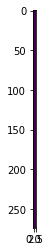

In [22]:
plt.imshow(np.transpose(image_list[-1],(1,2,0))[1])
plt.show()

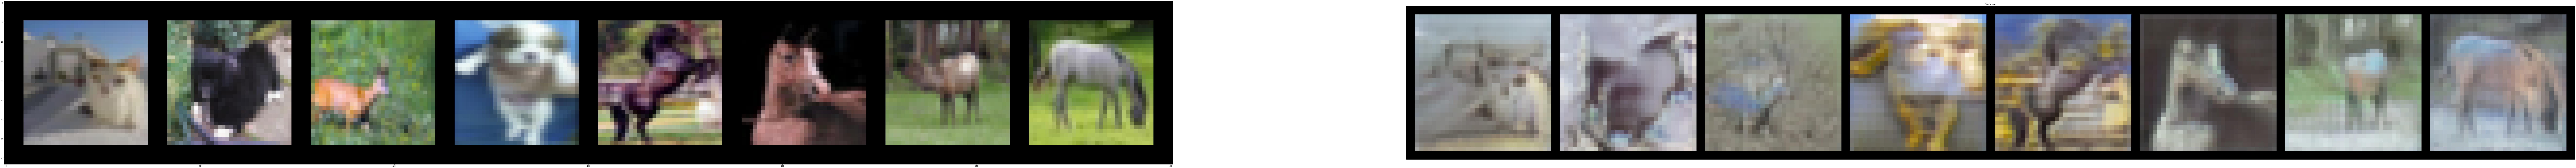

tensor(0.9775)
tensor(0.9214)
tensor(0.9587)
tensor(0.9143)
tensor(0.9479)
tensor(0.9280)
tensor(0.9806)
tensor(0.9506)
Similarity is 0.9473897740244865


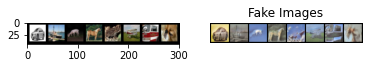

tensor(0.9528)
tensor(0.9621)
tensor(0.7213)
tensor(0.9669)
tensor(0.8893)
tensor(0.9614)
tensor(0.9473)
tensor(0.9671)
Similarity is 0.9209955036640167


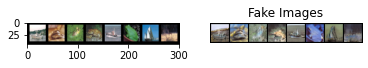

tensor(0.9767)
tensor(0.9531)
tensor(0.9699)
tensor(0.9862)
tensor(0.9768)
tensor(0.9130)
tensor(0.9002)
tensor(0.9323)
Similarity is 0.951020136475563


In [23]:
plt.figure(figsize = (300, 300))
for i in range(3):
  plt.subplot(3, 2, 1)
  color = data_dict["color"+str(10*(i+1))]
  plt.imshow(np.transpose(vutils.make_grid(color[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
  plt.subplot(3, 2, 2)
  image_list = []
  gray = data_dict["gray"+str(10*(i+1))]
  #plt.figure(figsize=(15,15))
  plt.axis("off")
  plt.title("Fake Images")
  #fake_1 = netG(gray).detach().cpu()
  with torch.no_grad():
          fake = netG(gray[0].to(device)).detach()
          fake = fake.cpu()
  image_list.append(vutils.make_grid(fake, padding=2, normalize=True))
  plt.imshow(np.transpose(image_list[-1],(1,2,0)))
  plt.show()
  print("Similarity is", similarity(fake, color[0]))

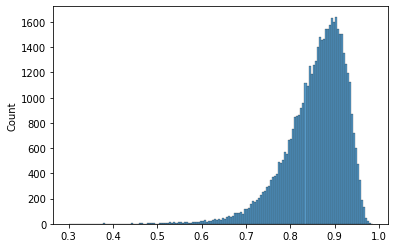

In [24]:
import seaborn as sb
simi = []
def similar(fake, real, simi):
  # fake and real are 8*3*32*32 tensors
  #comparison = []
  for i in range(8):
    dot_prod = torch.sum(fake[i]*real[i])
    fake_norm = torch.norm(fake[i])
    real_norm = torch.norm(real[i])
    similarity = dot_prod/(fake_norm*real_norm)
    simi.append(similarity.item())
    
  #return np.mean(comparison)

for i in range(NUM_TRAIN//8):
  data = data_dict["color" + str(i)]
  gray_data = data_dict["gray" + str(i)]
  with torch.no_grad():
    fake = netG(gray[0].to(device)).detach()
    fake = fake.cpu() 
  similar(fake, data[0], simi)

sb.histplot(simi)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


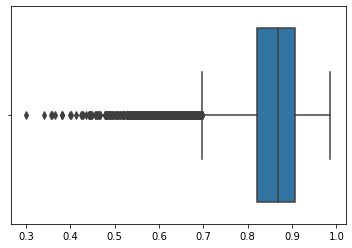

In [25]:
sb.boxplot(simi)

In [26]:
np.mean(simi)

0.8567472732192278

In [27]:
#loader_test = DataLoader(cifar10_test, batch_size=8, sampler=ChunkSampler(NUM_TRAIN+1000, NUM_TRAIN))

In [28]:
'''data_teat = {}
for i,data in enumerate(loader_test, 0):
  data_test["test"+str(i)] = data'''

'data_teat = {}\nfor i,data in enumerate(loader_test, 0):\n  data_test["test"+str(i)] = data'

In [29]:
'''for i in range(1000//8):
  data = data_dict["color" + str(i)]
  gray_data = data_dict["gray" + str(i)]
  with torch.no_grad():
    fake = netG(gray[0].to(device)).detach()
    fake = fake.cpu() 
  similar(fake, data[0], simi)'''


'for i in range(1000//8):\n  data = data_dict["color" + str(i)]\n  gray_data = data_dict["gray" + str(i)]\n  with torch.no_grad():\n    fake = netG(gray[0].to(device)).detach()\n    fake = fake.cpu() \n  similar(fake, data[0], simi)'